In [1]:
import os
import numpy as np
import rasterio as rio
import geopandas as gpd
import shapely as shp
from rasterio.plot import show 
from coasty import postprocess 
from skimage import measure
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt


EPSG:4326


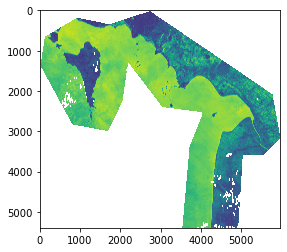

<AxesSubplot:>

In [3]:
folder = os.path.join(os.getcwd(),'test_data')
mndwi_path = os.path.join(folder,'1_2_LE07_125053_20110121.tif')
#binary_path = os.path.join(folder,'2020_L8_test_bin.tif')
raster = rio.open(mndwi_path)
mndwi = raster.read(1)
print(raster.crs)
show(mndwi)
#show(binary)

In [4]:
with rio.open(mndwi_path,"r") as raster:
    mndwi = raster.read(1)
    thres = threshold_otsu(mndwi[~np.isnan(mndwi)])
    print(thres)

0.20424692


In [128]:
thres = threshold_otsu(mndwi[~np.isnan(mndwi)])
mndwi_contours = postprocess.subpixel_contours(mndwi_path,30,threshold=thres,sigma=1)
#bin_contours = postprocess.subpixel_contours(binary_path,30,0.5,sigma=1)
mndwi_contours.to_file(os.path.join(folder,"2020_mndwi_contours1"),driver="GeoJSON")
#bin_contours.to_file(os.path.join(folder,"2020_bin_contours1"),driver="GeoJSON")

In [12]:
def subpixel_contours(raster_path, value):
    with rio.open(raster_path,"r") as raster:
        array = raster.read(1)
        t = raster.transform
        aff_matrix= [t.b, t.a, t.e, t.d,t.xoff+t.a*0.5,t.yoff+t.e*0.5]
        contours = measure.find_contours(array,value)
        lines = []
        for contour in contours: 
            line = shp.geometry.asLineString(contour)
            #line = shp.affinity.affine_transform(line,aff_matrix)
            lines.append(line)
    lines_gdf = gpd.GeoDataFrame(geometry=lines,crs= raster.crs)
    lines_gdf.geometry = lines_gdf.geometry.affine_transform(aff_matrix)
    return lines_gdf

In [13]:
%%time
thres = threshold_otsu(mndwi[~np.isnan(mndwi)])
mndwi_contours = subpixel_contours(mndwi_path,0.207)
mndwi_contours.to_file(os.path.join(folder,"1_2_LE07_125053_20110121_contours"),driver="GeoJSON")

DriverError: Failed to create GeoJSON datasource: /home/ronja/Documents/Master_thesis/Code/VN_coastline_dynamics/data/test_data/1_2_LE07_125053_20110121_contours: /home/ronja/Documents/Master_thesis/Code/VN_coastline_dynamics/data/test_data/1_2_LE07_125053_20110121_contours: No such file or directory

In [29]:
if not mndwi_contours.crs == "EPSG:3857":
    print("Reproject file...")
    mndwi_contours = mndwi_contours.to_crs( "EPSG:3857")
buffer = gpd.read_file(os.path.join(os.getcwd(),'data','VN_buffer_5km'))
con_clean = gpd.clip(mndwi_contours,buffer)
con_clean = postprocess.remove_small_lines(con_clean,3000)
con_clean.to_file(os.path.join(folder,"P0_2011_test_slc"),driver="GeoJSON")

<AxesSubplot:>

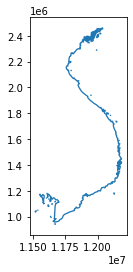

In [26]:
buffer.plot()

In [135]:
tiles = gpd.read_file(os.path.join(os.getcwd(),"data","VN_processing_polygons_new"))
tiles_old = gpd.read_file(os.path.join(os.getcwd(),"data","VN_processing_polygons"))
tiles_old

,left,top,right,bottom,id,geometry
0,37432.367012,1.218004e+06,5.374324e+05,1.018004e+06,0,"POLYGON ((11602835.090 1123914.899, 11592118.1..."
1,537432.367012,1.018004e+06,1.037432e+06,8.180045e+05,1,"POLYGON ((11689029.334 1029516.378, 11687477.7..."
2,537432.367012,1.218004e+06,1.037432e+06,1.018004e+06,2,"POLYGON ((11844338.533 1175062.418, 11908779.7..."
3,537432.367012,1.218004e+06,1.037432e+06,1.018004e+06,3,"POLYGON ((12120362.288 1200231.934, 12136087.5..."
4,537432.367012,1.218004e+06,1.037432e+06,1.018004e+06,4,"POLYGON ((11908779.731 1138803.097, 11844338.5..."
5,537432.367012,1.418004e+06,1.037432e+06,1.218004e+06,5,"POLYGON ((12020760.191 1232405.447, 12115278.7..."
6,537432.367012,1.618004e+06,1.037432e+06,1.418004e+06,6,"POLYGON ((12144470.849 1436220.020, 12158389.4..."
7,537432.367012,1.818004e+06,1.037432e+06,1.618004e+06,7,"POLYGON ((12119182.834 1643410.780, 12098065.4..."
8,537432.367012,2.018004e+06,1.037432e+06,1.818004e+06,8,"POLYGON ((11961214.364 1854375.901, 11932624.6..."
9,537432.367012,2.218004e+06,1.037432e+06,2.018004e+06,9,"POLYGON ((11788958.522 2066635.599, 11756082.0..."
